In [55]:
import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

from skimage.feature import greycomatrix, greycoprops
import mahotas as mt # Mahotas library for GLCM calculation
from skimage import feature # feature.local_binary_pattern for LBP calculation

import joblib as jb

# BRISK - Feature Point Detector

In [56]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_balanced_brisk_rf.pkl")

In [57]:
voc.shape

(25, 64)

In [58]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_balanced'

In [59]:
testing_names = os.listdir(test_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1
    

In [60]:
image_paths[:10]

['./waste_images/test_balanced\\Aluminium\\Aluminium17.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium49.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium5.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium55.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium57.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium63.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium70.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium83.JPG',
 './waste_images/test_balanced\\Aluminium\\Aluminium85.JPG',
 './waste_images/test_balanced\\Battery\\Battery100.JPG']

In [61]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [62]:
# Extract features with BRISK method 
# Create List where all the descriptors will be stored
des_list = []

# BRISK is a good replacement to SIFT. ORB also works but didn't work well for this example
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))

In [63]:
des_list[0][1].shape

(1044, 64)

In [64]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor))

In [65]:
descriptors.shape

(149221, 64)

In [66]:
# Calculate the histogram of features
# vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [67]:
test_features.shape

(122, 25)

In [68]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

In [69]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)
#print (cm)
#showconfusionmatrix(cm)

accuracy =  0.27049180327868855


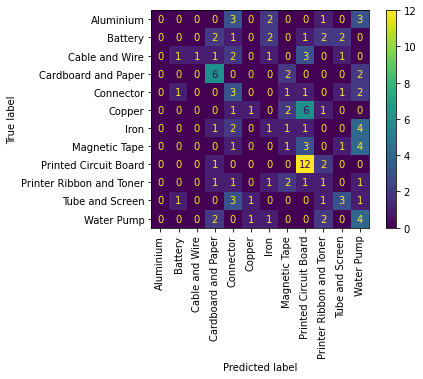

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

## Accuracy per Class 

In [71]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.        , 0.        , 0.1       , 0.6       , 0.33333333,
       0.09090909, 0.1       , 0.1       , 0.8       , 0.125     ,
       0.3       , 0.4       ])

In [72]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.0,
 'Battery': 0.0,
 'Cable and Wire': 0.1,
 'Cardboard and Paper': 0.6,
 'Connector': 0.33,
 'Copper': 0.09,
 'Iron': 0.1,
 'Magnetic Tape': 0.1,
 'Printed Circuit Board': 0.8,
 'Printer Ribbon and Toner': 0.12,
 'Tube and Screen': 0.3,
 'Water Pump': 0.4}

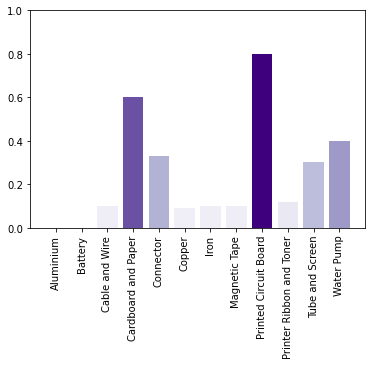

In [73]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

In [ ]:
'''
#For classification of unknown files we can print the predictions
#Print the Predictions 
print ("Image =", image_paths)
print ("prediction ="  + str(predictions))
#np.transpose to save data into columns, otherwise saving as rows
np.savetxt ('mydata.csv', np.transpose([image_paths, predictions]),fmt='%s', delimiter=',', newline='\n')
'''

# GLCM Haralick Features

In [74]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_balanced_glcm_rf.pkl")

In [75]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_balanced'

In [76]:
testing_names = os.listdir(test_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [77]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [78]:
# Create List where all the descriptors will be stored
des_list = []

In [79]:
def extract_glcm_features(image):
        
        # Calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # Return the mean
        #ht_mean = textures.mean(axis=0)
        #return ht_mean
        
        return textures

In [80]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_glcm_features(gray_img)
    des_list.append((image_path, des))

In [81]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [82]:
# Calculate the histogram of features
# vq Assigns codes from a code book to observations. 
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [83]:
np.unique(test_features)

array([0., 1., 2., 3., 4.], dtype=float32)

In [84]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

In [85]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)

accuracy =  0.16393442622950818


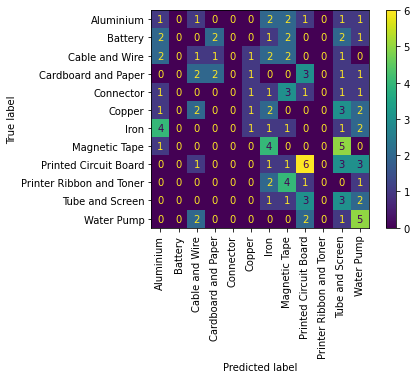

In [86]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

## Accuracy per Class 

In [87]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.11111111, 0.        , 0.1       , 0.2       , 0.        ,
       0.09090909, 0.1       , 0.        , 0.4       , 0.        ,
       0.3       , 0.5       ])

In [88]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.11,
 'Battery': 0.0,
 'Cable and Wire': 0.1,
 'Cardboard and Paper': 0.2,
 'Connector': 0.0,
 'Copper': 0.09,
 'Iron': 0.1,
 'Magnetic Tape': 0.0,
 'Printed Circuit Board': 0.4,
 'Printer Ribbon and Toner': 0.0,
 'Tube and Screen': 0.3,
 'Water Pump': 0.5}

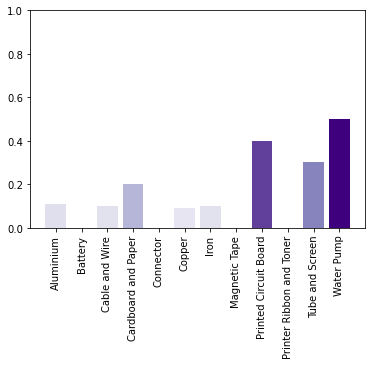

In [89]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

# LBP - Local Binary Patterns

In [90]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_balanced_lbp_rf.pkl")

In [91]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_balanced'

In [92]:
testing_names = os.listdir(test_path)

In [93]:
# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [94]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [95]:
# Create list where all the descriptors will be stored
des_list = []

In [96]:
def extract_lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    '''
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist
    '''
    
    return lbp

In [97]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    #gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_lbp_features(im)
    des_list.append((image_path, des))

In [98]:
len(des_list)

122

In [99]:
removal_list = []

for image_path, descriptor in des_list[1:]:
    if (descriptor.shape[1] != (640)):
        #print(image_path, descriptor.shape)
        removal_list.append(image_path)

In [100]:
len(removal_list)

5

In [101]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
        if image_path not in removal_list:
            #print(image_path)
            descriptors = np.vstack((descriptors, descriptor))

In [102]:
adjusted_des_list = []

for item in des_list:
    if item[0] not in removal_list:
        #print(item[0])
        adjusted_des_list.append(item)

In [103]:
len(adjusted_des_list)

117

In [104]:
def list_difference(b, a):
    c = list(b)
    for item in a:
        try:
            c.remove(item)
        except ValueError:
            pass            #or maybe you want to keep a values here
    return c

In [105]:
adjusted_image_paths = list_difference(image_paths, removal_list)
len(adjusted_image_paths)

117

In [106]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

test_features = np.zeros((len(adjusted_image_paths), k), "float32")

for i in range(len(adjusted_image_paths)):
    words, distance = vq(adjusted_des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [107]:
labels_classes = {'Aluminium':0, 'Battery':1, 'Cable and Wire':2, 'Cardboard and Paper':3, 'Connector':4,
                'Copper':5, 'Iron':6, 'Magnetic Tape':7, 'Printed Circuit Board':8, 
                'Printer Ribbon and Toner':9, 'Tube and Screen':10, 'Water Pump':11}

list(labels_classes.keys())

['Aluminium',
 'Battery',
 'Cable and Wire',
 'Cardboard and Paper',
 'Connector',
 'Copper',
 'Iron',
 'Magnetic Tape',
 'Printed Circuit Board',
 'Printer Ribbon and Toner',
 'Tube and Screen',
 'Water Pump']

In [108]:
classesToRemove = []

for key in labels_classes:
    for string in removal_list:
        if key in string:
            #print(labels_classes[key])
            classesToRemove.append(labels_classes[key])

In [109]:
classesToRemove

[2, 5, 5, 8, 9]

In [110]:
adjusted_image_classes = list_difference(image_classes, classesToRemove)

In [111]:
len(adjusted_image_classes)

117

In [112]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in adjusted_image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

In [113]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)

accuracy =  0.21367521367521367


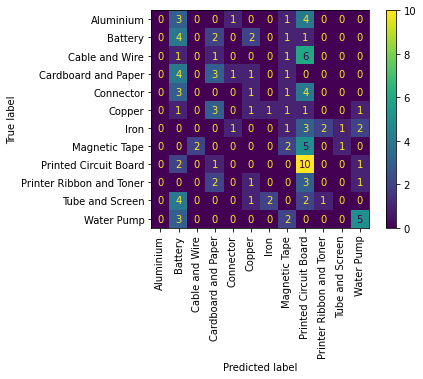

In [114]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

## Accuracy per Class 

In [115]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.        , 0.4       , 0.        , 0.3       , 0.        ,
       0.11111111, 0.        , 0.2       , 0.71428571, 0.        ,
       0.        , 0.5       ])

In [116]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.0,
 'Battery': 0.4,
 'Cable and Wire': 0.0,
 'Cardboard and Paper': 0.3,
 'Connector': 0.0,
 'Copper': 0.11,
 'Iron': 0.0,
 'Magnetic Tape': 0.2,
 'Printed Circuit Board': 0.71,
 'Printer Ribbon and Toner': 0.0,
 'Tube and Screen': 0.0,
 'Water Pump': 0.5}

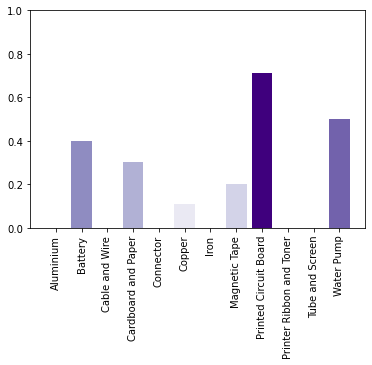

In [117]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

### Final comments

... interpretation ...